Source: https://archive.ics.uci.edu/ml/datasets/Wholesale+customers#

Each row in the dataset refers to a business that is the client of a wholesale distributor. It includes the annual spending in monetary units (m.u.) on diverse product categories. The Channel column has 2 unique values for the type of businesses: horeca (Hotel/Restaurant/Cafa) and retailers. 
	

In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import plotly.express as explot
import itertools
import warnings

from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn import metrics
from sklearn.metrics import silhouette_score
from scipy.stats import boxcox, probplot, norm, shapiro

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
warnings.filterwarnings("ignore")

In [27]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/COGS109/Wholesale_customers_data.csv')

In [28]:
data.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [29]:
# store Channel column. Could be used as labels for the dataset?
Y = data['Channel']

# Change this if planning to use these 2 columns
data.drop(['Region', 'Channel'], axis = 1, inplace = True)

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Fresh             440 non-null    int64
 1   Milk              440 non-null    int64
 2   Grocery           440 non-null    int64
 3   Frozen            440 non-null    int64
 4   Detergents_Paper  440 non-null    int64
 5   Delicassen        440 non-null    int64
dtypes: int64(6)
memory usage: 20.8 KB


In [31]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Fresh,440.0,12000.297727,12647.328865,3.0,3127.75,8504.0,16933.75,112151.0
Milk,440.0,5796.265909,7380.377175,55.0,1533.00,3627.0,7190.25,73498.0
Grocery,440.0,7951.277273,9503.162829,3.0,2153.00,4755.5,10655.75,92780.0
Frozen,440.0,3071.931818,4854.673333,25.0,742.25,1526.0,3554.25,60869.0
Detergents_Paper,440.0,2881.493182,4767.854448,3.0,256.75,816.5,3922.00,40827.0
Delicassen,440.0,1524.870455,2820.105937,3.0,408.25,965.5,1820.25,47943.0


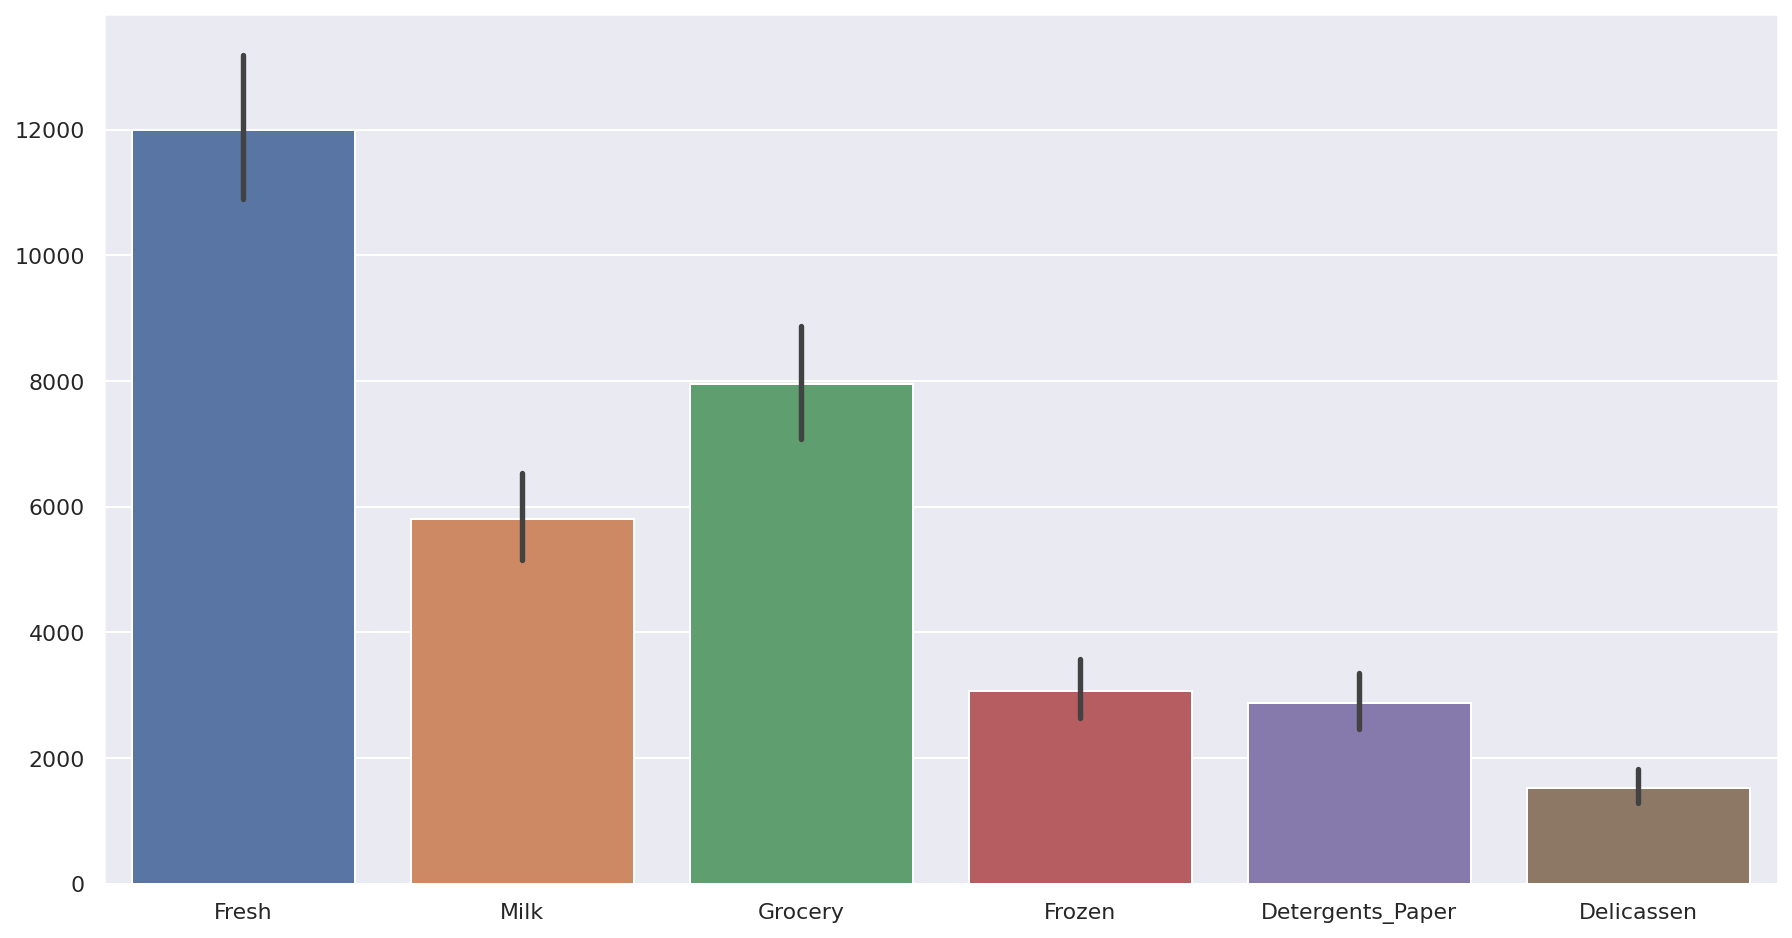

In [32]:
plt.figure(figsize = (15,8))
sns.barplot(data=data)
plt.show()

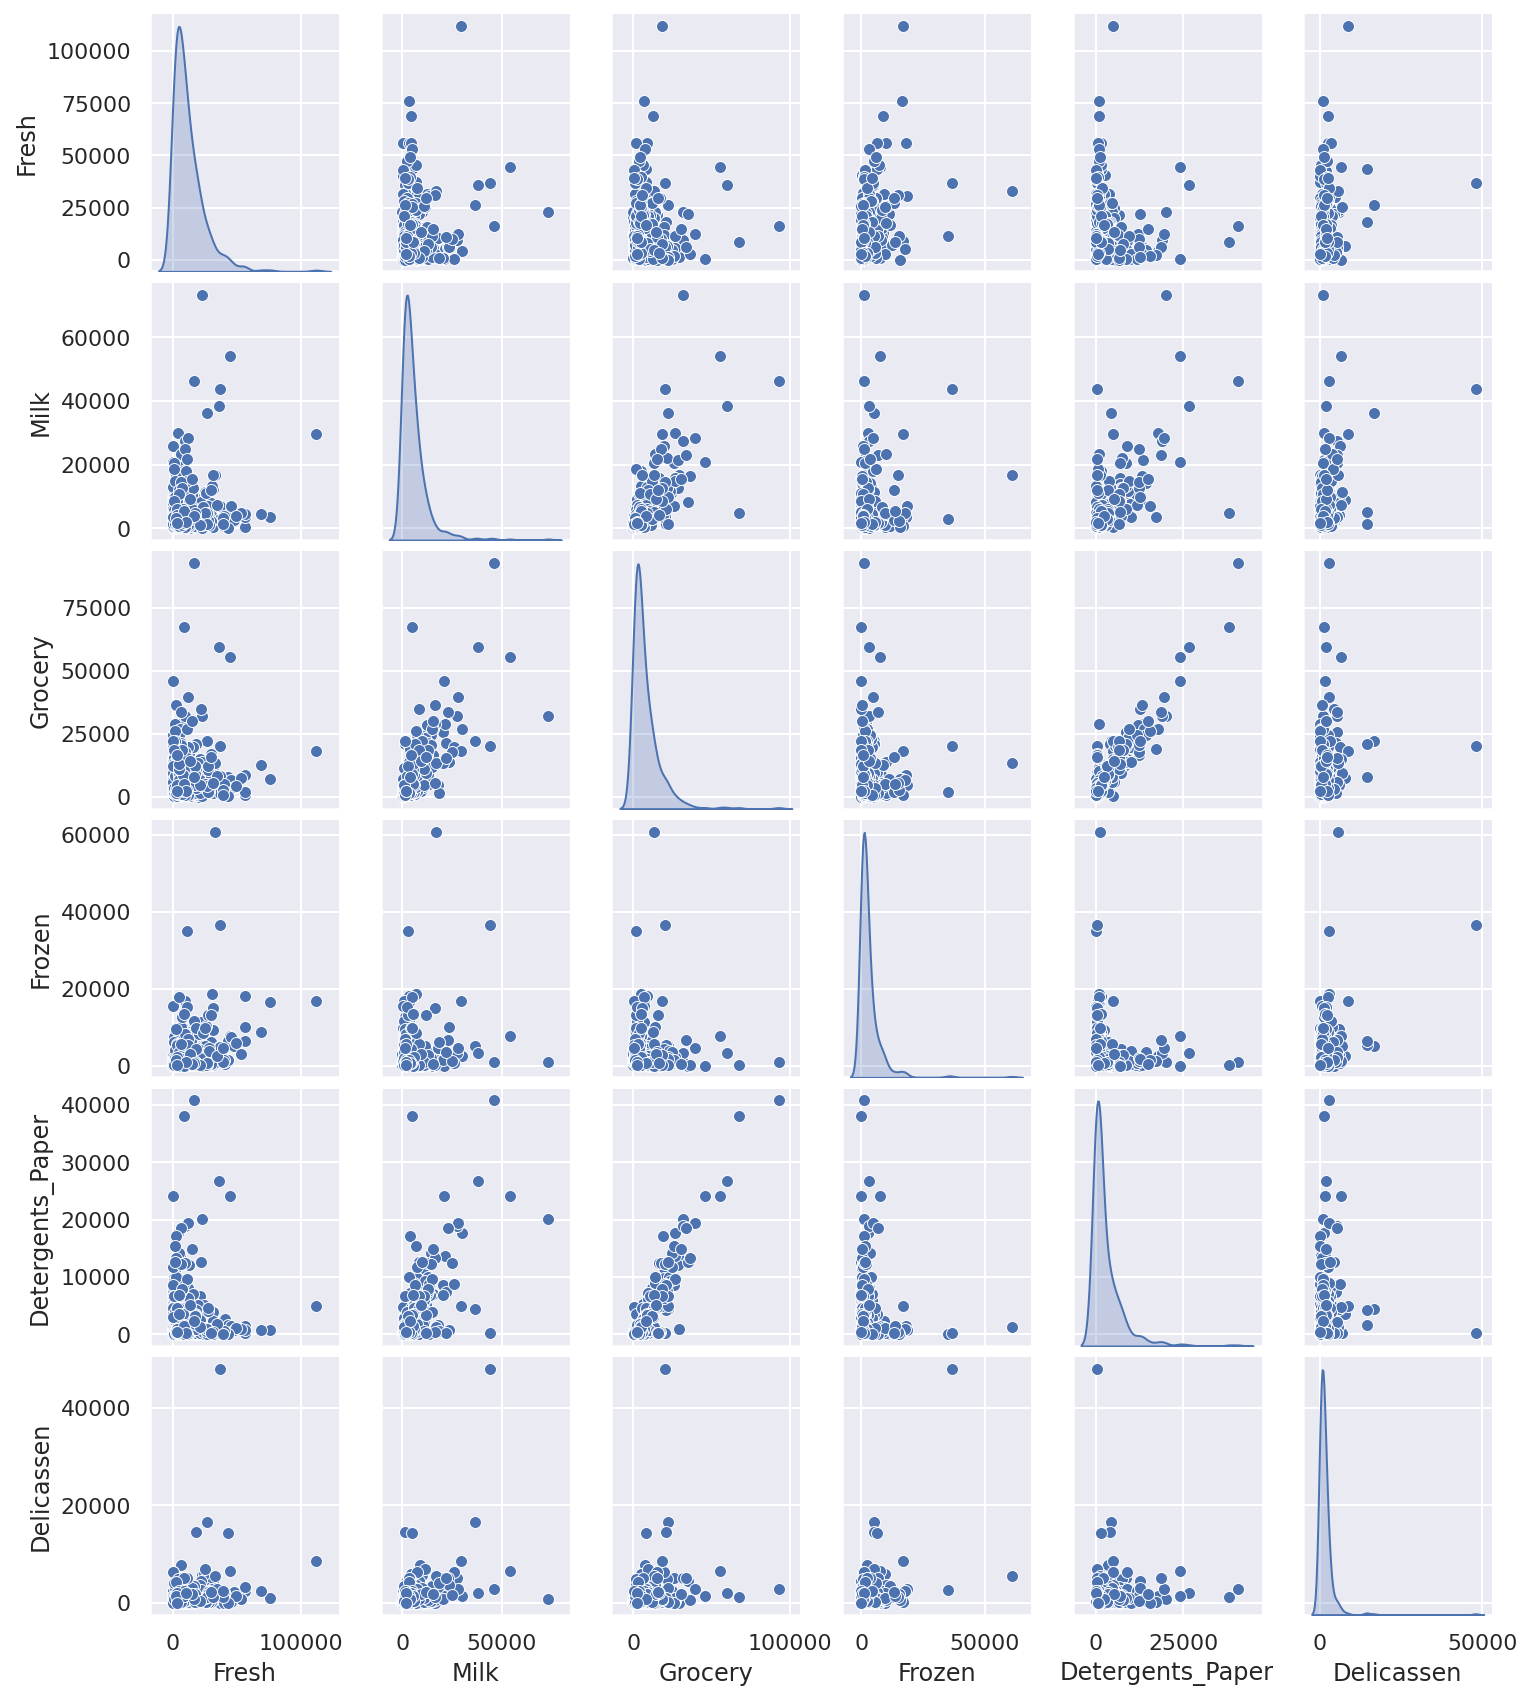

In [33]:
_ = sns.pairplot(data, diag_kind = 'kde', height=2, aspect=0.9)

Data is not normall distributed. We can try different transformations to find one that suits this dataset.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.probplot.html#scipy.stats.probplot

https://stackoverflow.com/questions/48108582/how-to-interpret-scipy-stats-probplot-results

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html


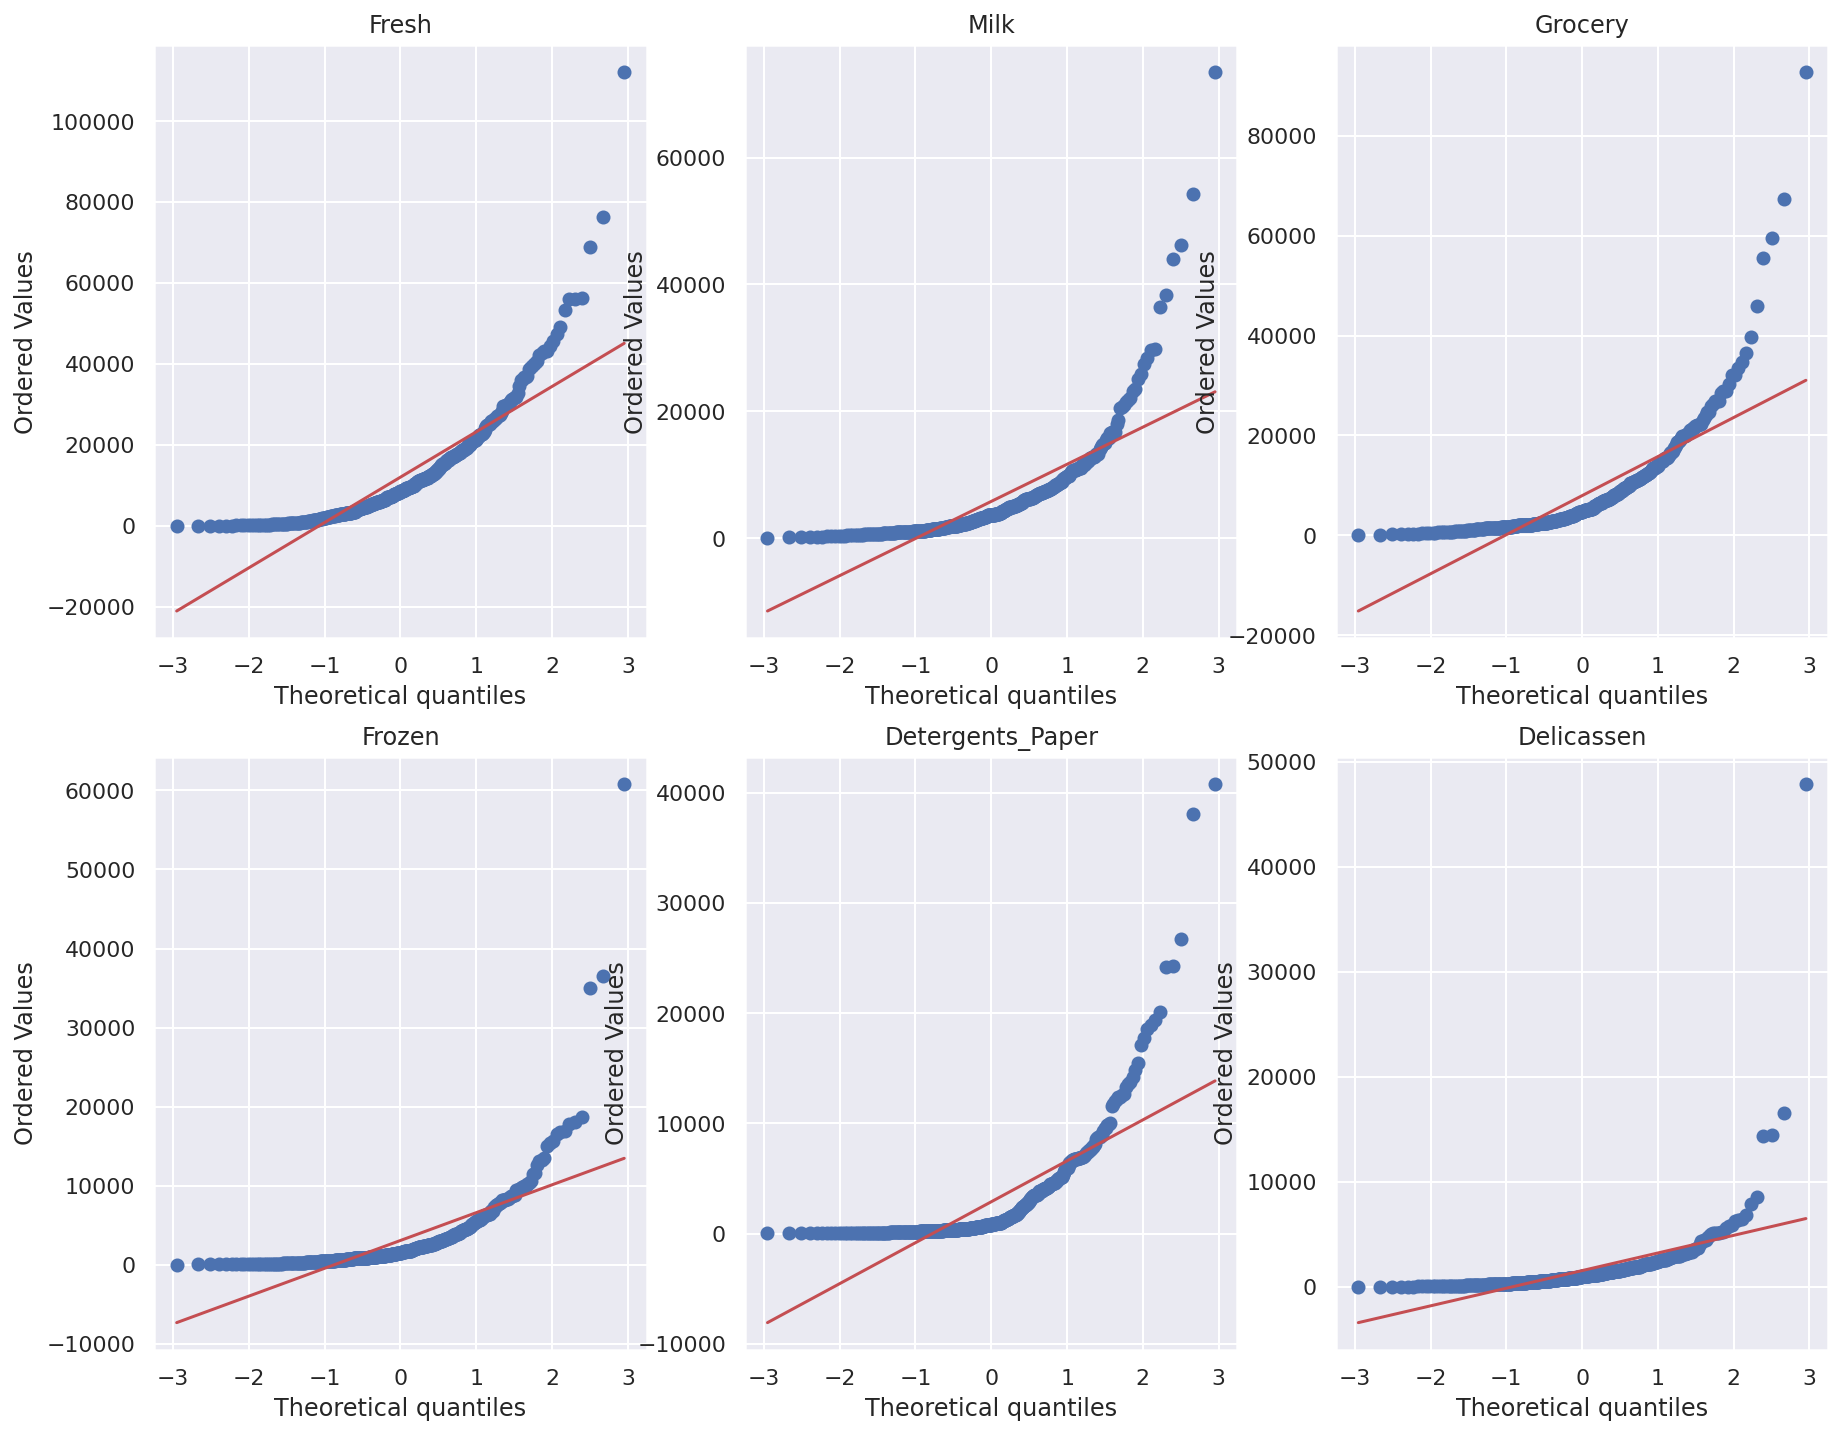

,Tests,p-value
Fresh,0.781436,7.918286e-24
Milk,0.628334,9.762062e-30
Grocery,0.676231,3.906209e-28
Frozen,0.528297,1.291332e-32
Detergents_Paper,0.605482,1.914593e-30
Delicassen,0.361068,1.753408e-36


In [34]:
# testing on regular data

test = {}
plt.figure(figsize=(15, 12))

for i in range(0,6):
    ax = plt.subplot(2, 3, i+1)
    probplot(x=data[data.columns[i]], dist=norm, plot=ax)
    plt.title(data.columns[i])
    test[data.columns[i]] = shapiro(data[data.columns[i]])
    
plt.show()

pd.DataFrame(test, index=['Tests', 'p-value']).T

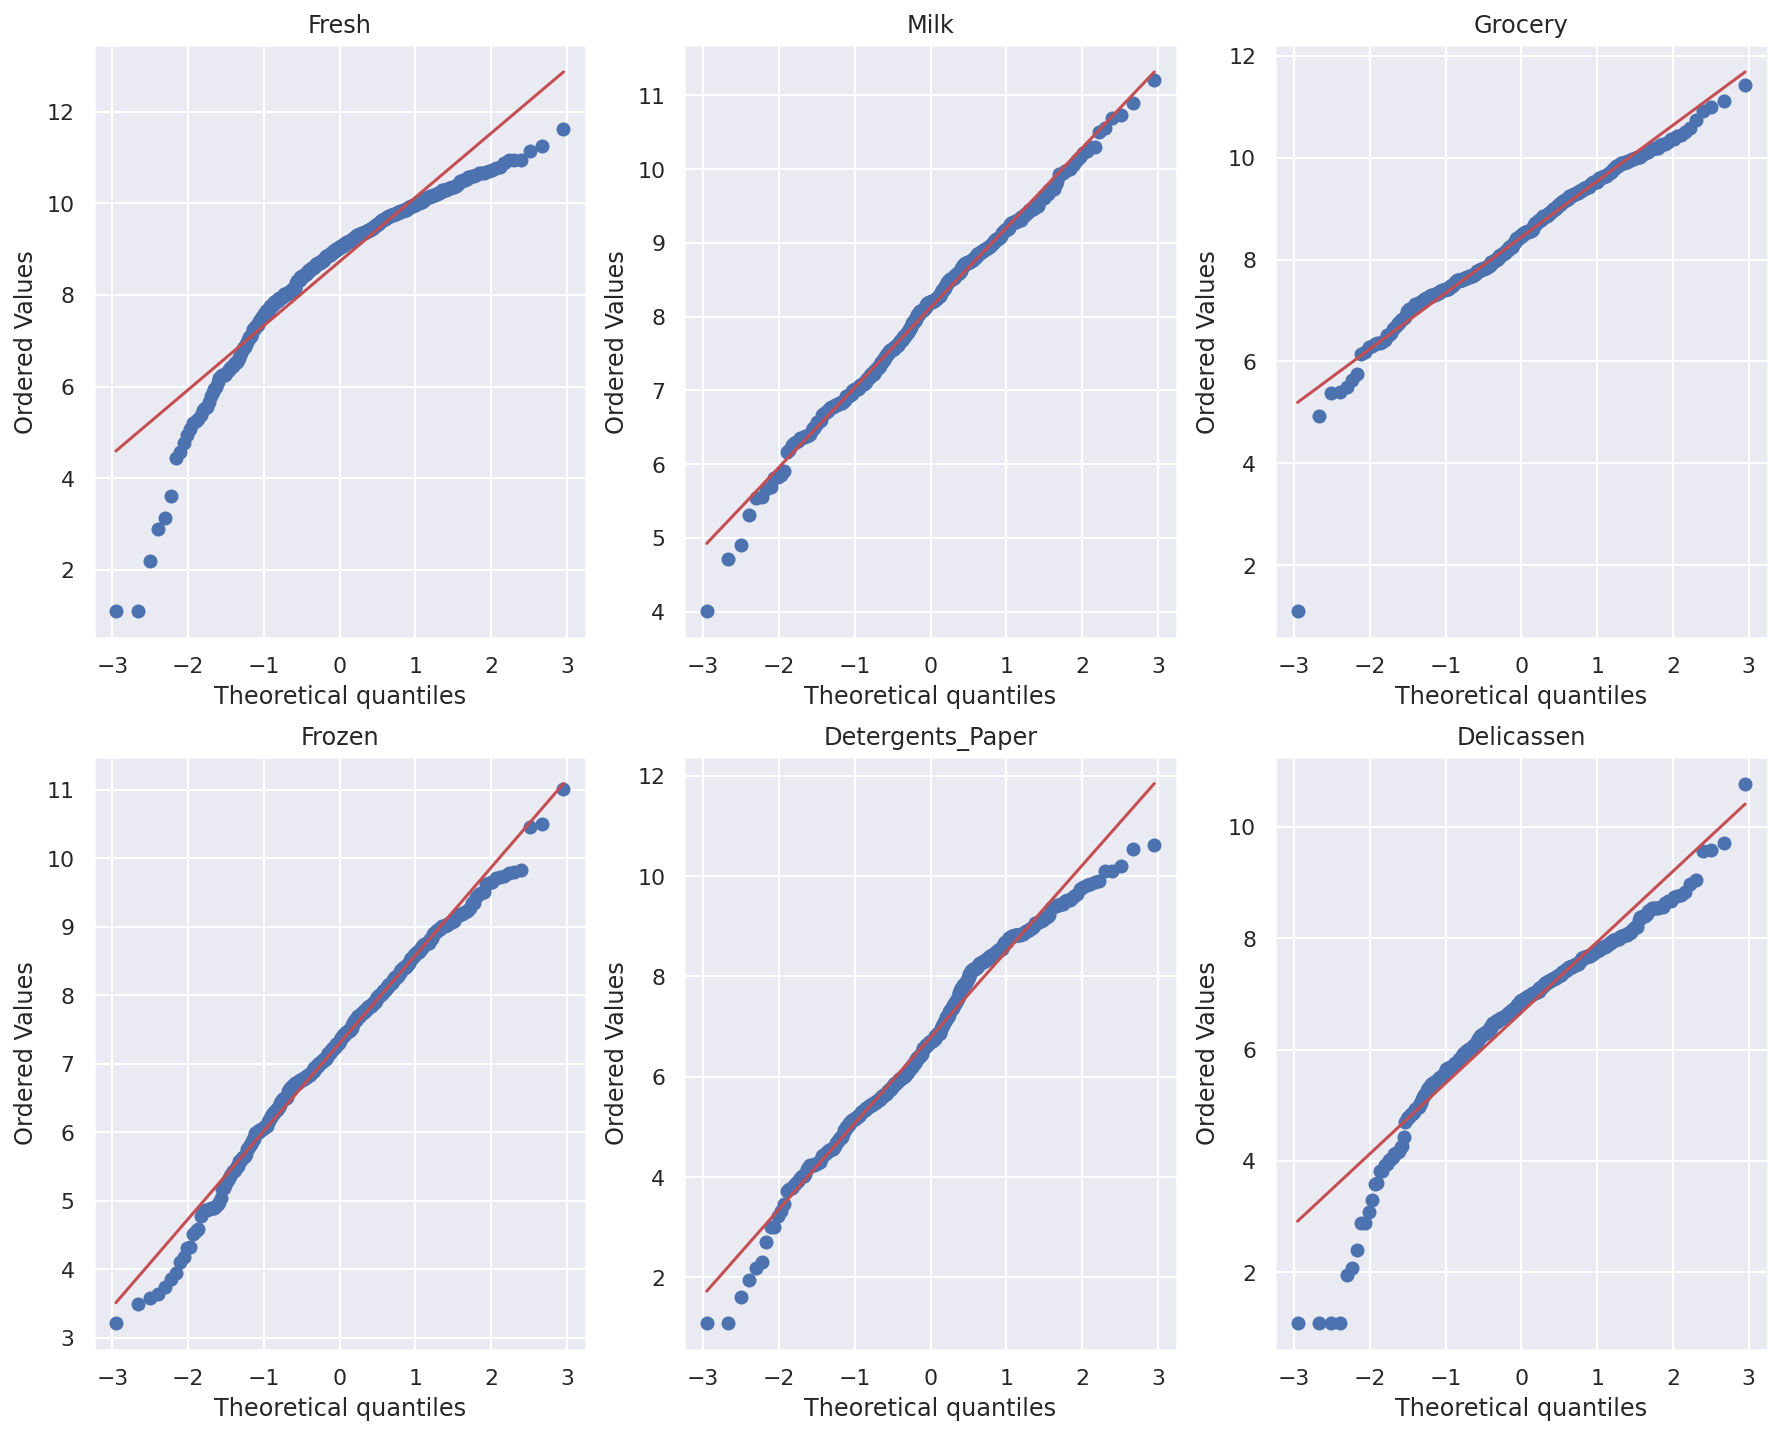

,Tests,p-value
Fresh,0.890065,3.303679e-17
Milk,0.994083,8.528145e-02
Grocery,0.964565,8.116720e-09
Frozen,0.990030,4.431482e-03
Detergents_Paper,0.981625,2.265693e-05
Delicassen,0.929627,1.575756e-13


In [35]:
# testing on log transformed data
log_data = np.log(data)

test = {}
plt.figure(figsize=(15, 12))

for i in range(0,6):
    ax = plt.subplot(2, 3, i+1)
    probplot(x=log_data[log_data.columns[i]], dist=norm, plot=ax)
    plt.title(log_data.columns[i])
    test[log_data.columns[i]] = shapiro(log_data[log_data.columns[i]])
    
plt.show()

pd.DataFrame(test, index=['Tests', 'p-value']).T

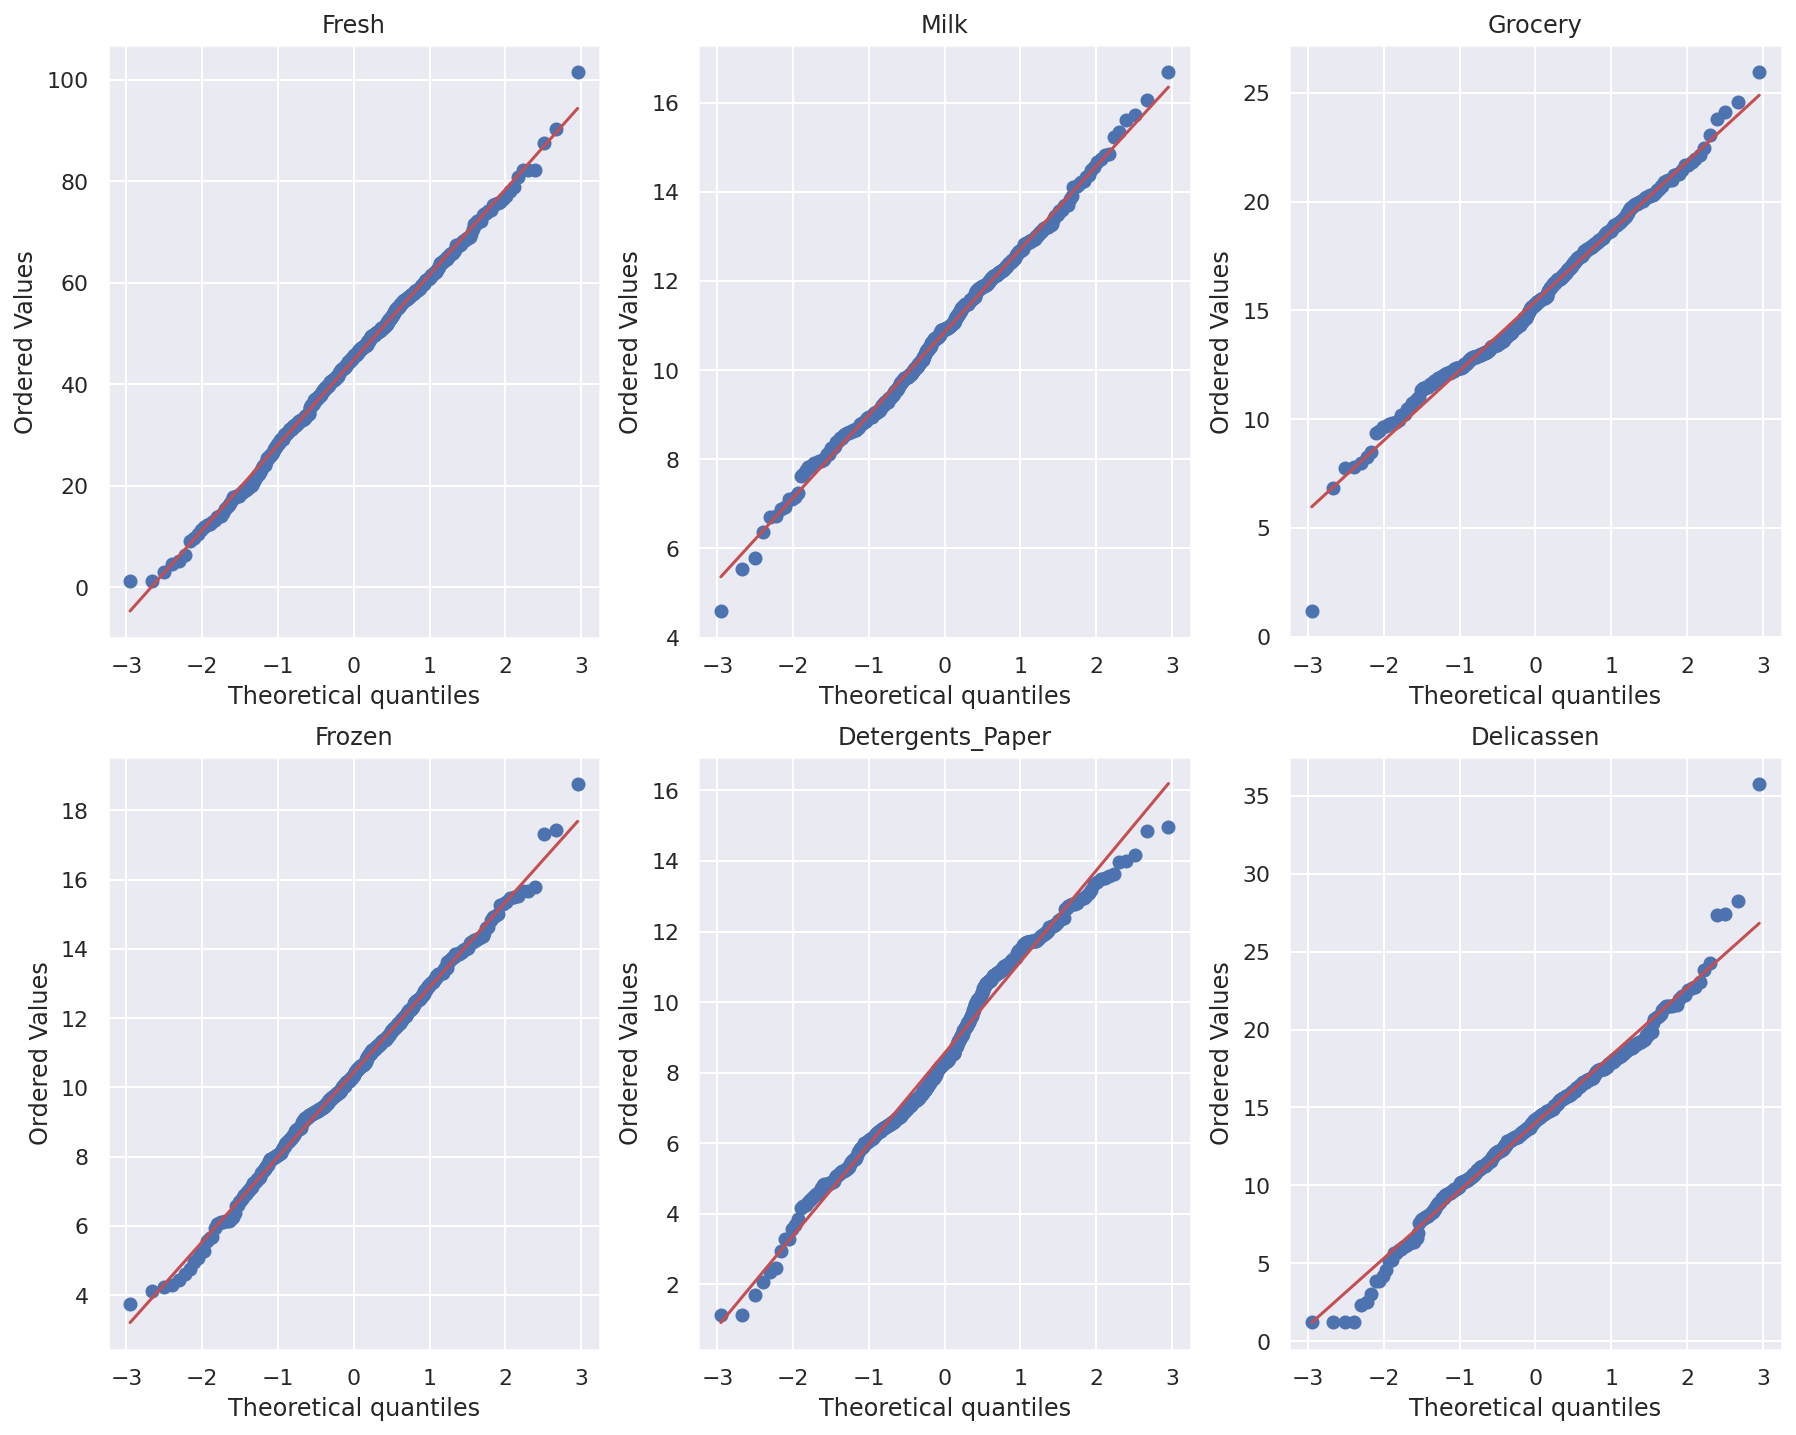

,Test,p-value
Fresh,0.997445,0.737682
Milk,0.996949,0.584299
Grocery,0.989161,0.002424
Frozen,0.997237,0.673424
Detergents_Paper,0.985208,0.000185
Delicassen,0.981869,0.000026


In [36]:
test = dict()

plt.figure(figsize=(15, 12))
plt.title('BoxCox Transformation')

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    x, _ = boxcox(data[data.columns[i]])
    probplot(x = x, dist=norm, plot=ax)
    plt.title(data.columns[i])
    test[data.columns[i]] = shapiro(x)
    
plt.show()

pd.DataFrame(test, index=['Test', 'p-value']).T

Standardize features by removing the mean and scaling to unit variance:

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [37]:
# use box-cox as the transformation of choice and apply StandardScaler

box = PowerTransformer(method='box-cox')
box_data = box.fit_transform(data)
stnrd_data = StandardScaler().fit_transform(box_data)

data_normal = pd.DataFrame(stnrd_data, columns=data.columns)
print("Standard Scaled Data:")
data_normal.head()


Standard Scaled Data:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,0.412646,0.979303,0.392937,-1.456705,0.617238,0.335779
1,-0.111180,0.995096,0.626729,0.079718,0.748629,0.599877
2,-0.196043,0.887891,0.408738,0.331996,0.790324,2.245295
3,0.457763,-0.965094,-0.156523,1.173643,-0.373844,0.606332
4,1.028704,0.412455,0.344961,0.741520,0.364211,1.738881


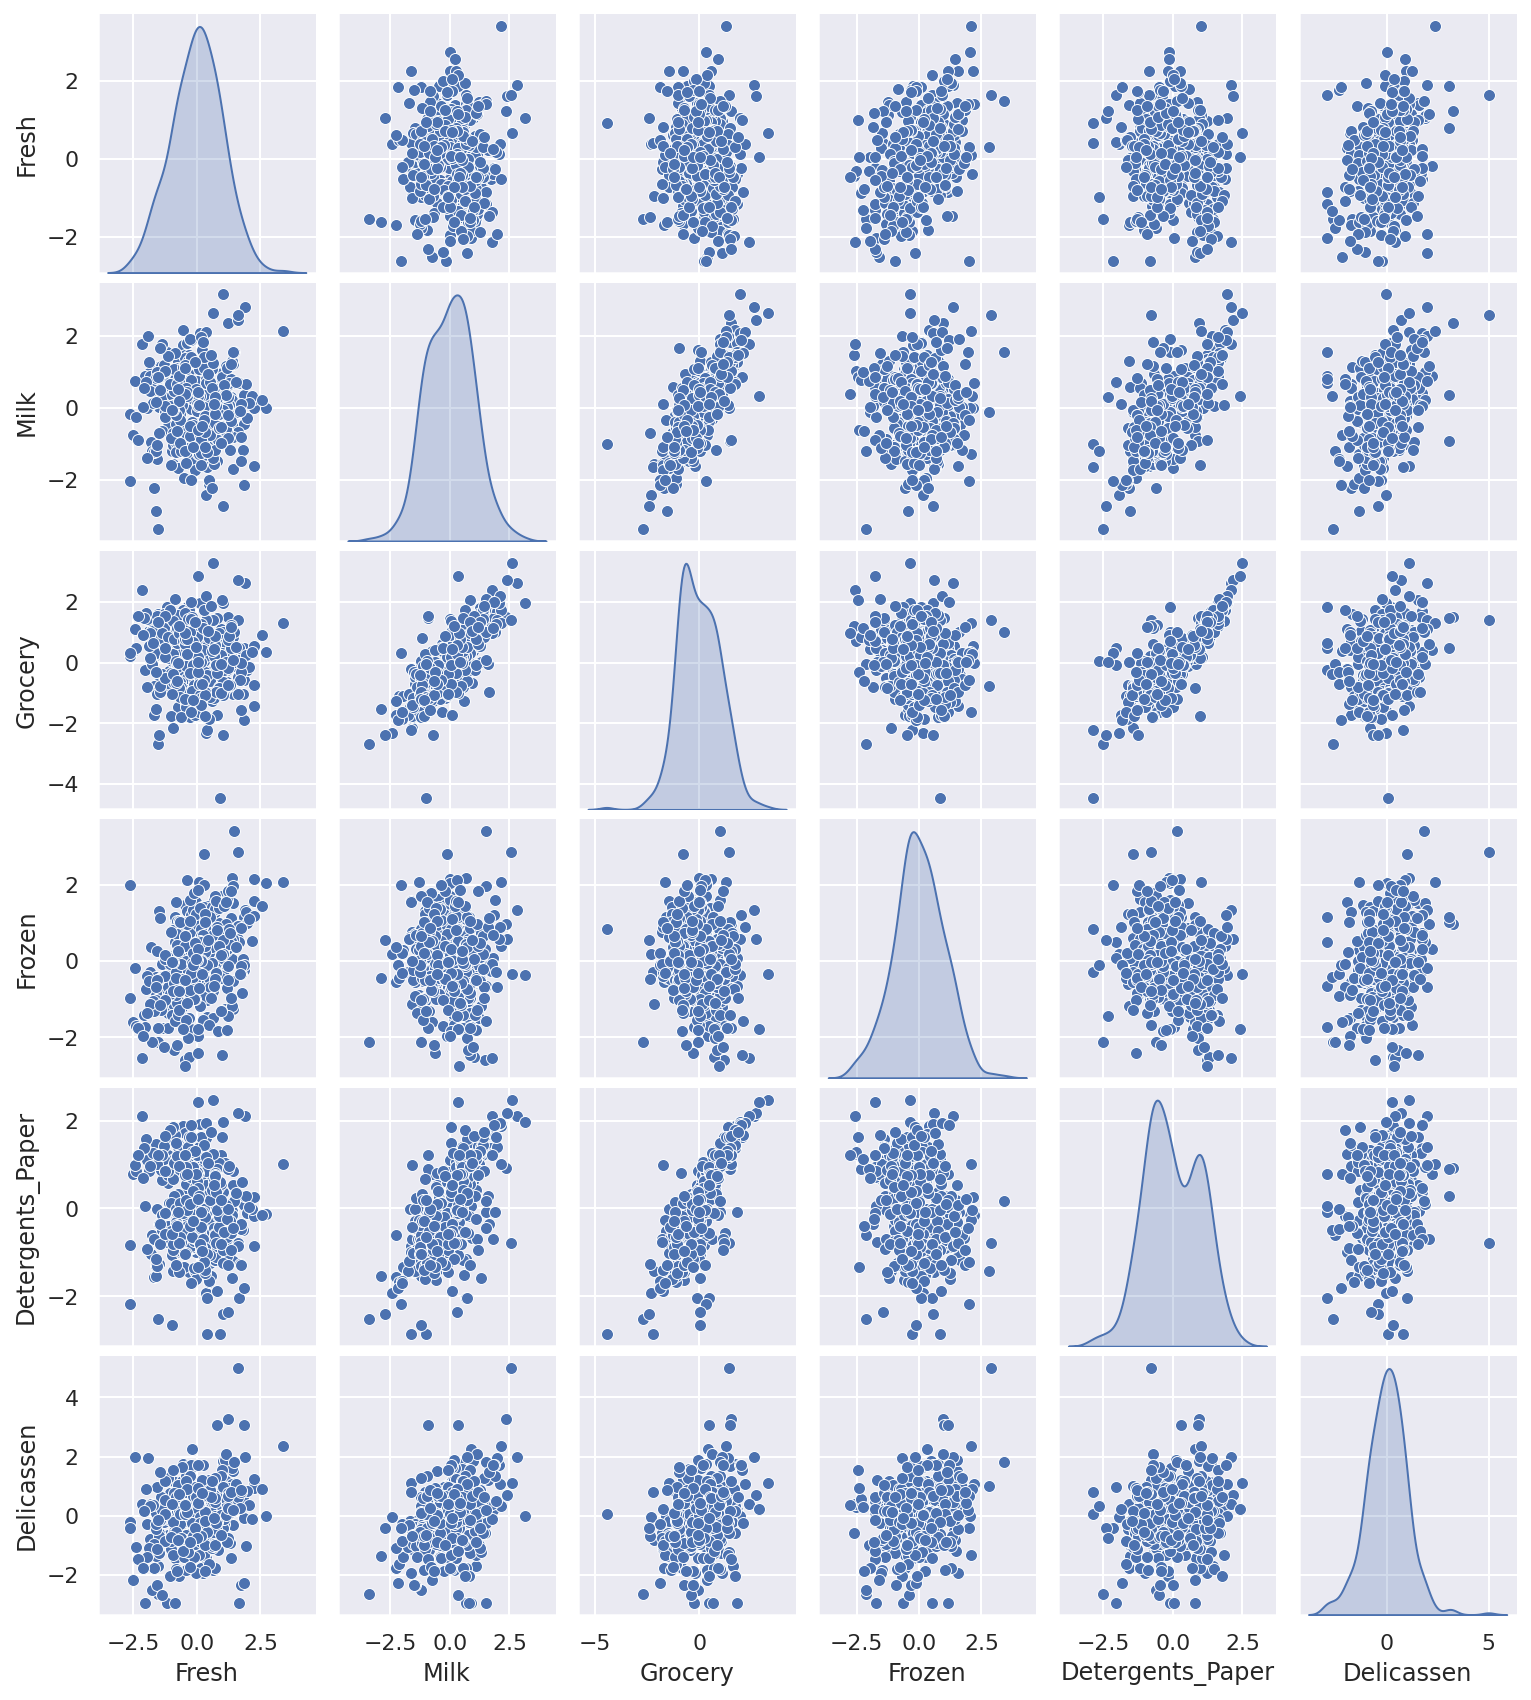

In [38]:
_ = sns.pairplot(data_normal, diag_kind = 'kde', height=2, aspect=0.9)

In [39]:
corr = data_normal.corr()
corr

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Fresh,1.000000,-0.023114,-0.106490,0.409108,-0.180152,0.274444
Milk,-0.023114,1.000000,0.777832,-0.044705,0.684856,0.384415
Grocery,-0.106490,0.777832,1.000000,-0.161393,0.818136,0.283831
Frozen,0.409108,-0.044705,-0.161393,1.000000,-0.219160,0.277641
Detergents_Paper,-0.180152,0.684856,0.818136,-0.219160,1.000000,0.178416
Delicassen,0.274444,0.384415,0.283831,0.277641,0.178416,1.000000


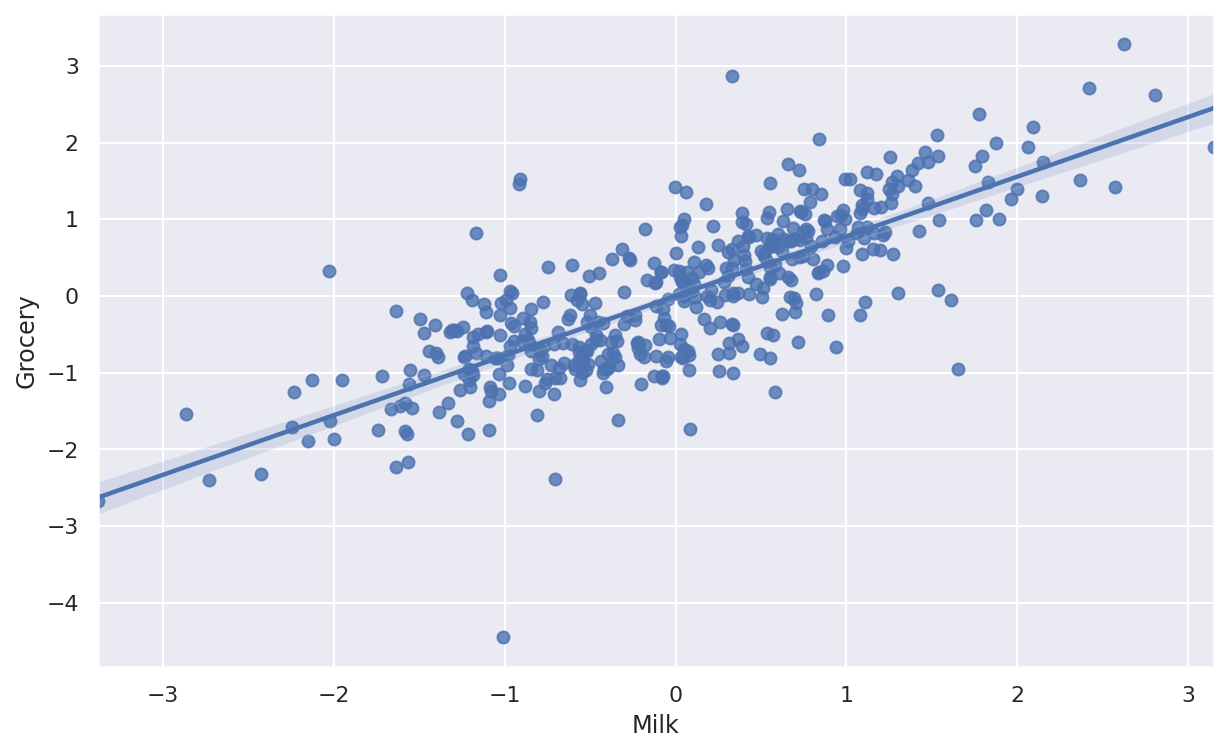

In [40]:
plt.figure(figsize=(10,6))
sns.regplot(data=data_normal, x="Milk",y="Grocery")
plt.show()

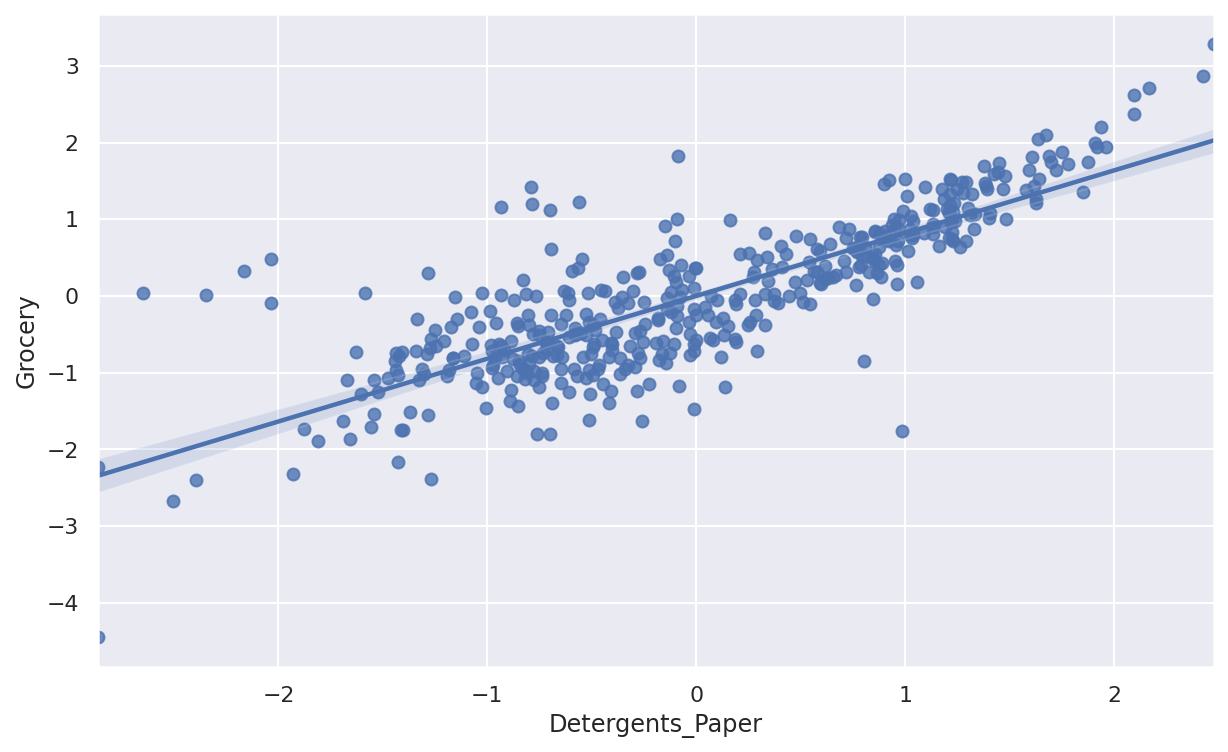

In [41]:
plt.figure(figsize=(10,6))
sns.regplot(data=data_normal, x="Detergents_Paper",y="Grocery")
plt.show()

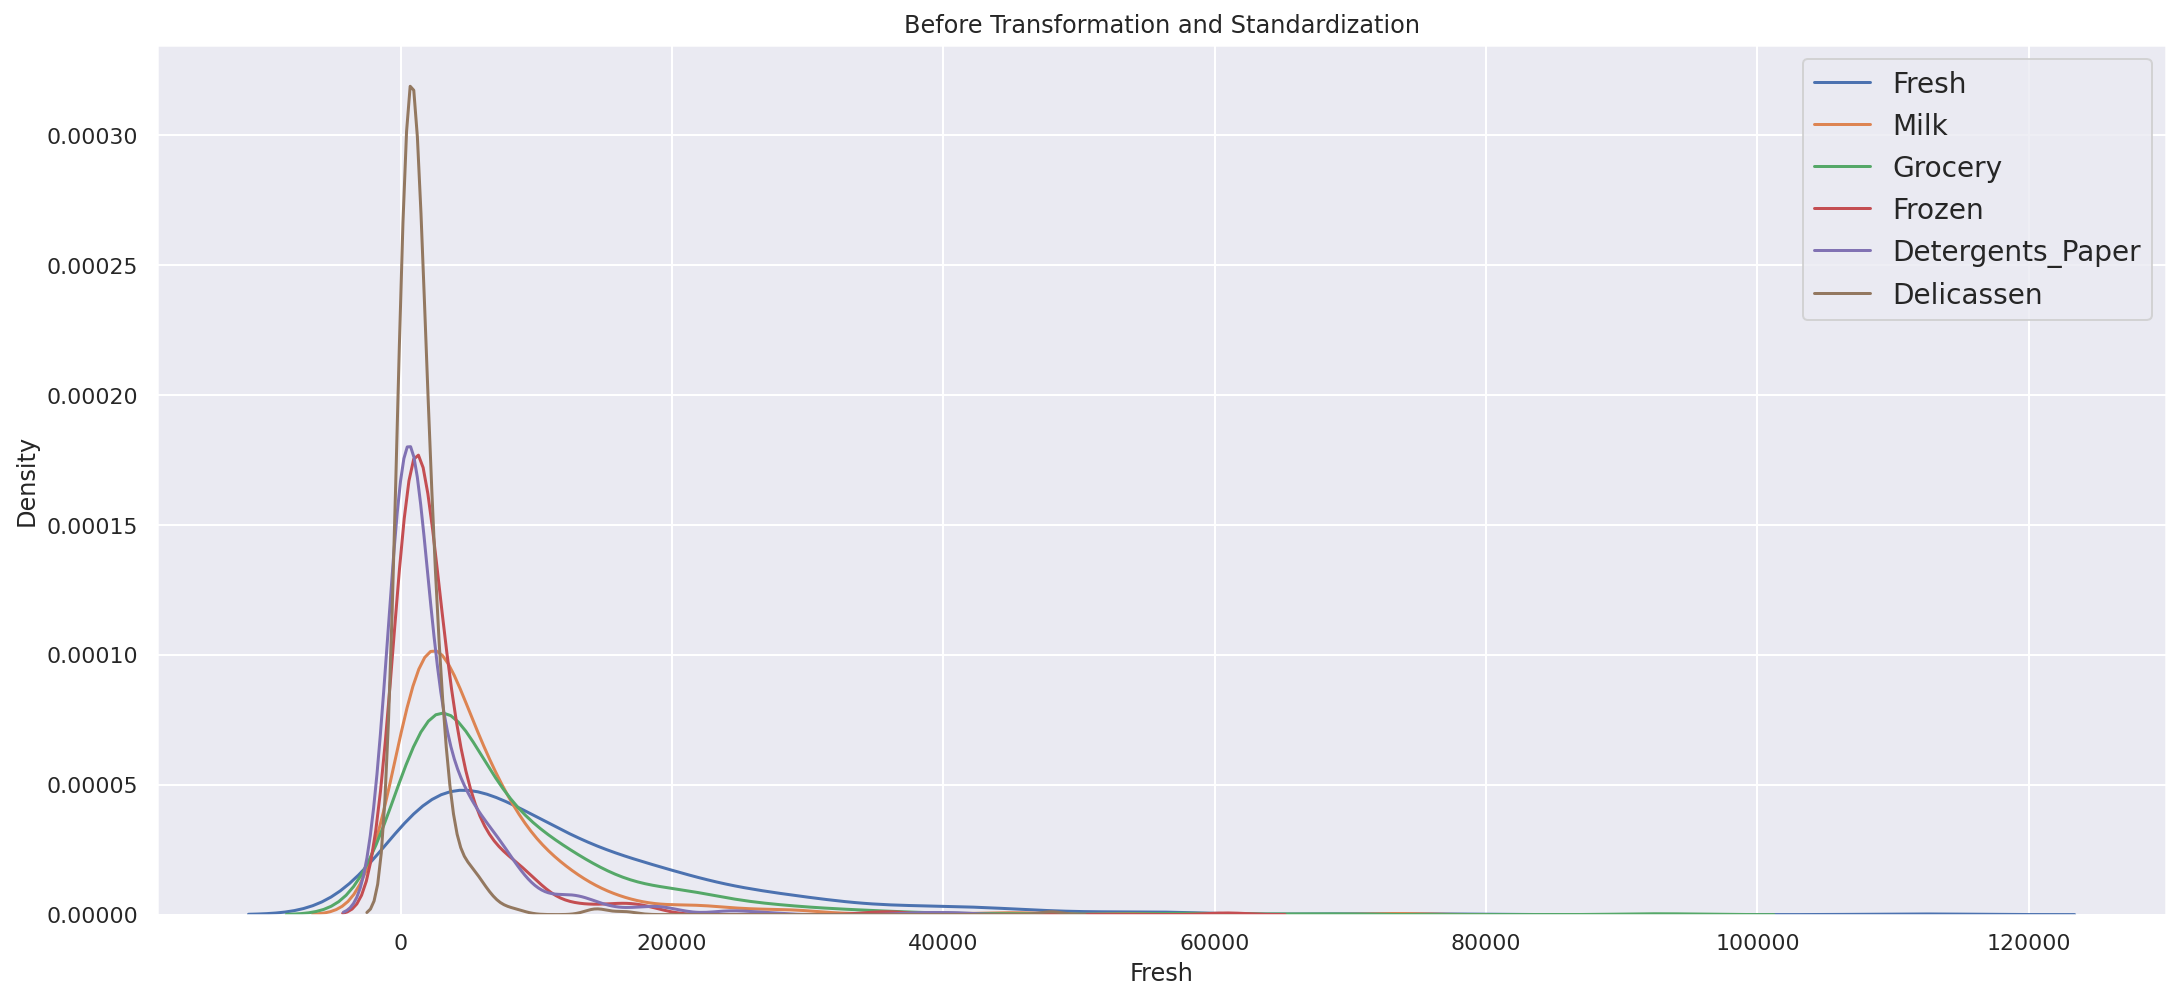

In [42]:
plt.figure(figsize = (18,8))
plt.title('Before Transformation and Standardization')

for cols in data.columns.values:
    ax = sns.kdeplot(data[cols], Label=cols)
    ax.legend(loc=0, prop={'size': 14})

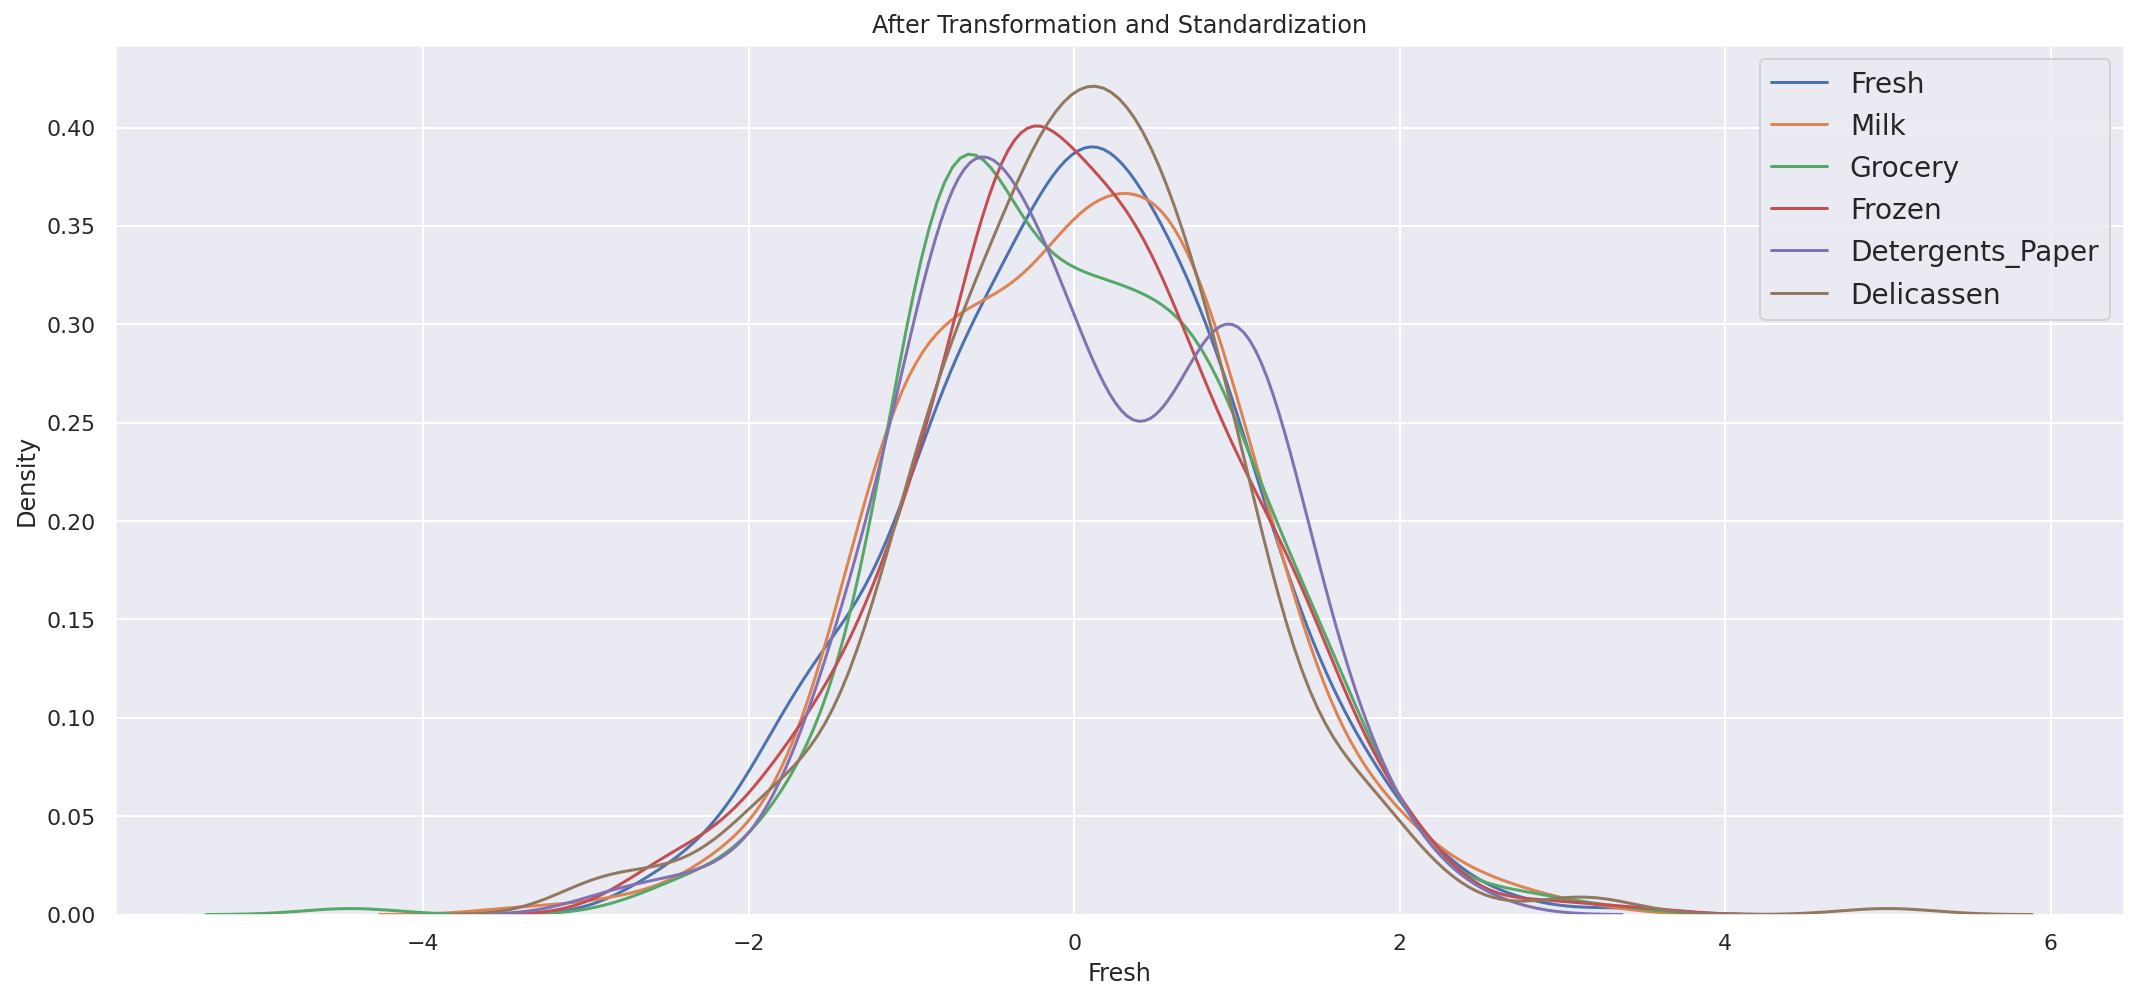

In [43]:
plt.figure(figsize = (18,8))
plt.title('After Transformation and Standardization')

for cols in data_normal.columns.values:
    ax = sns.kdeplot(data_normal[cols], Label=cols)
    ax.legend(loc=0, prop={'size': 14})

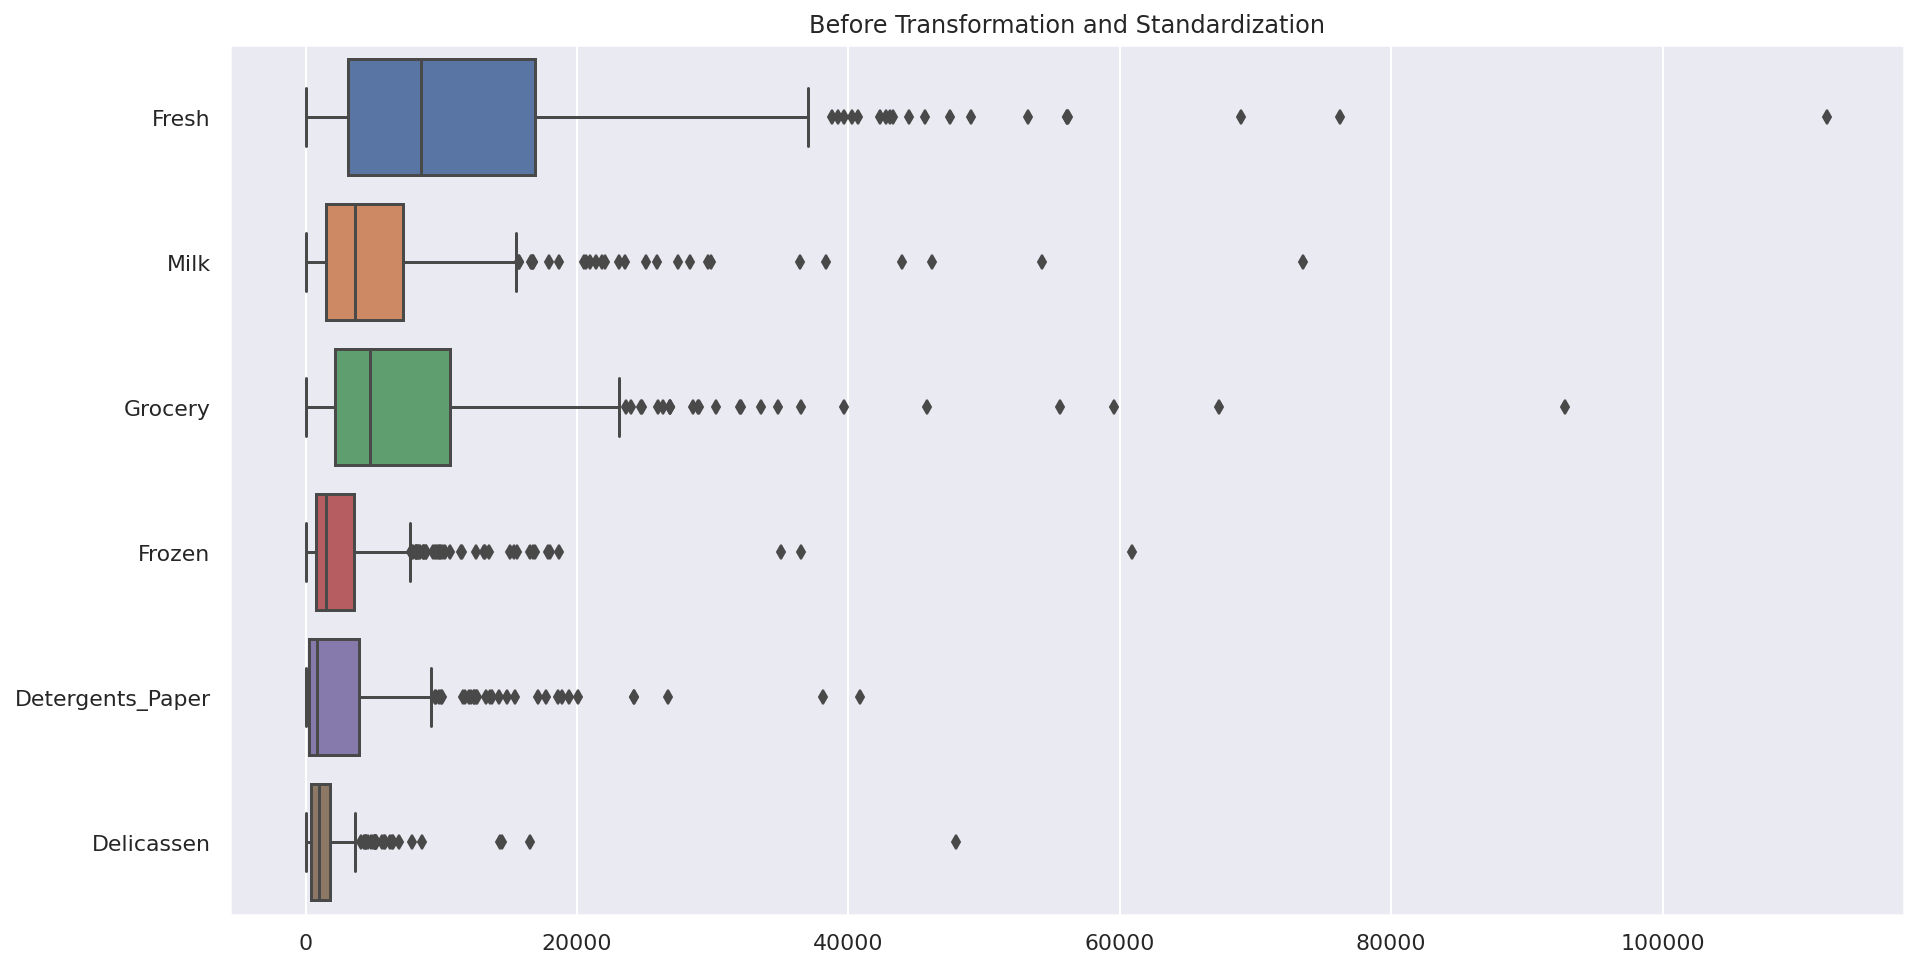

In [44]:
plt.figure(figsize = (15,8))
sns.boxplot(data=data, orient='h')
plt.title('Before Transformation and Standardization')
plt.show()

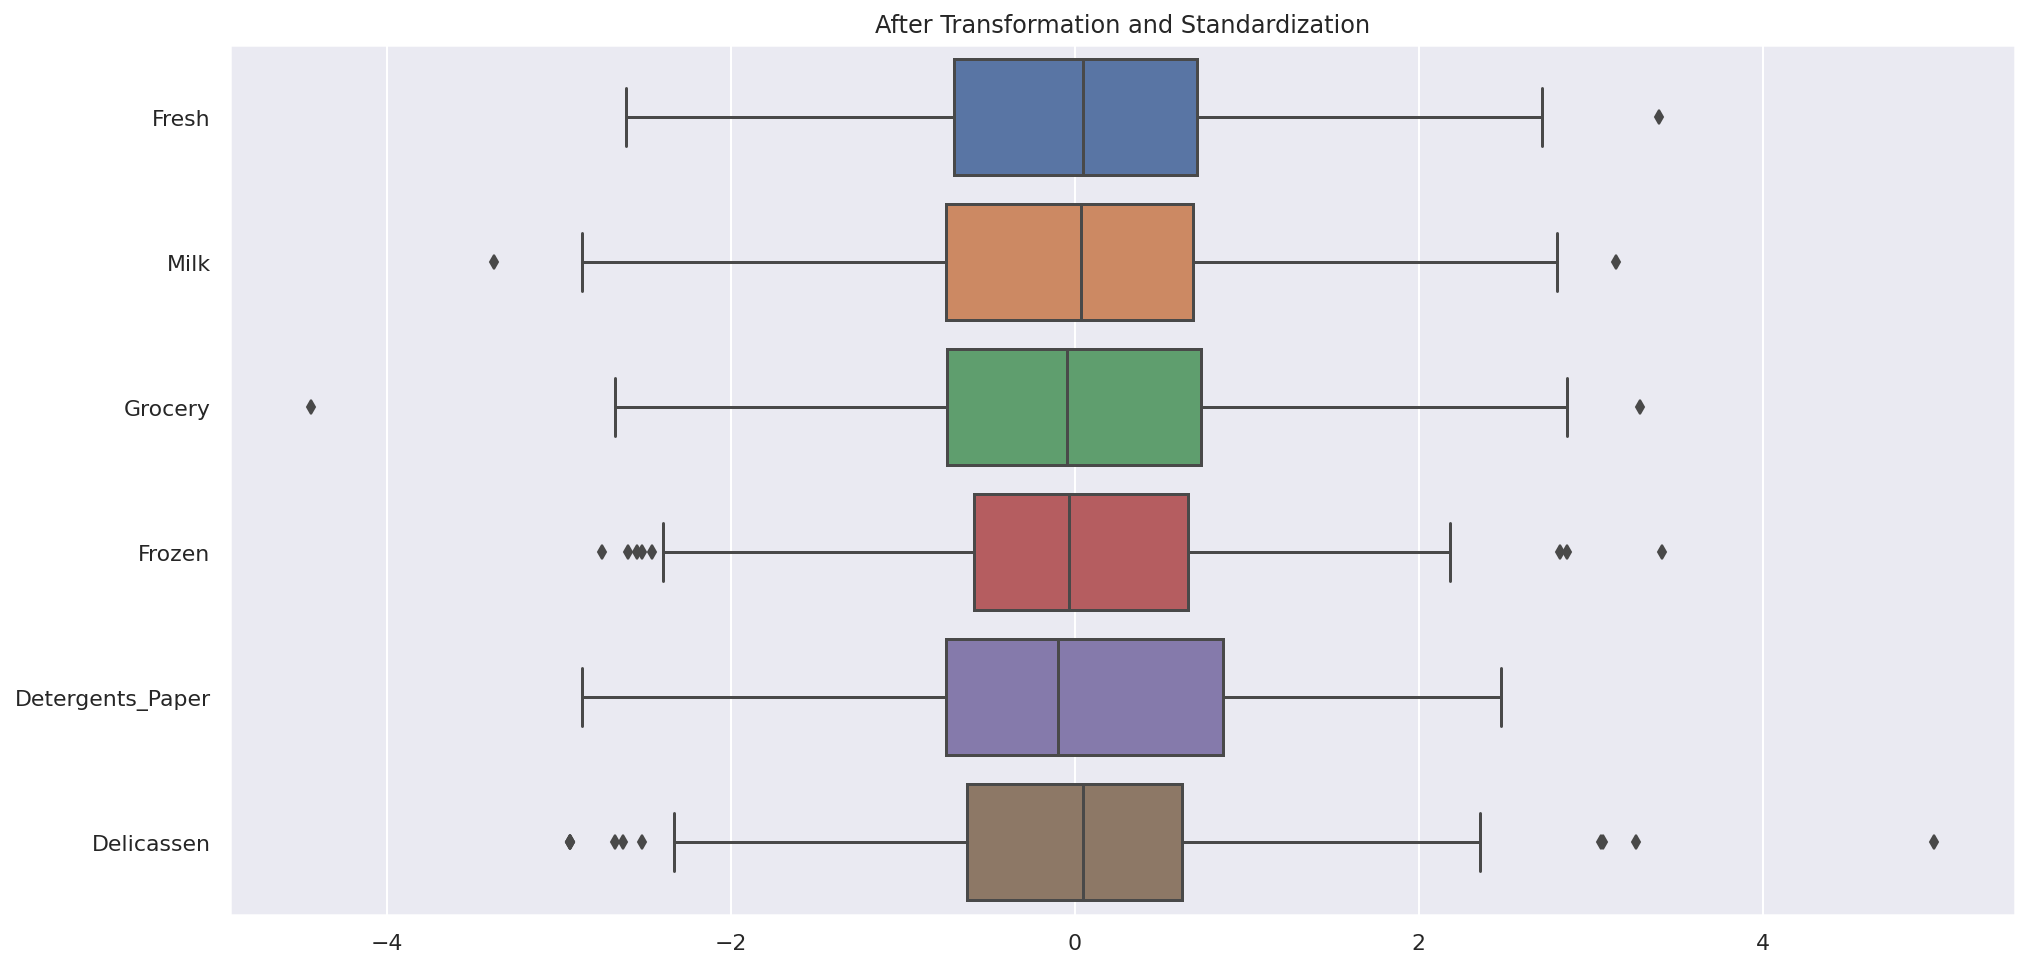

In [45]:
plt.figure(figsize = (16,8))
sns.boxplot(data=data_normal, orient='h')
plt.title('After Transformation and Standardization')
plt.show()

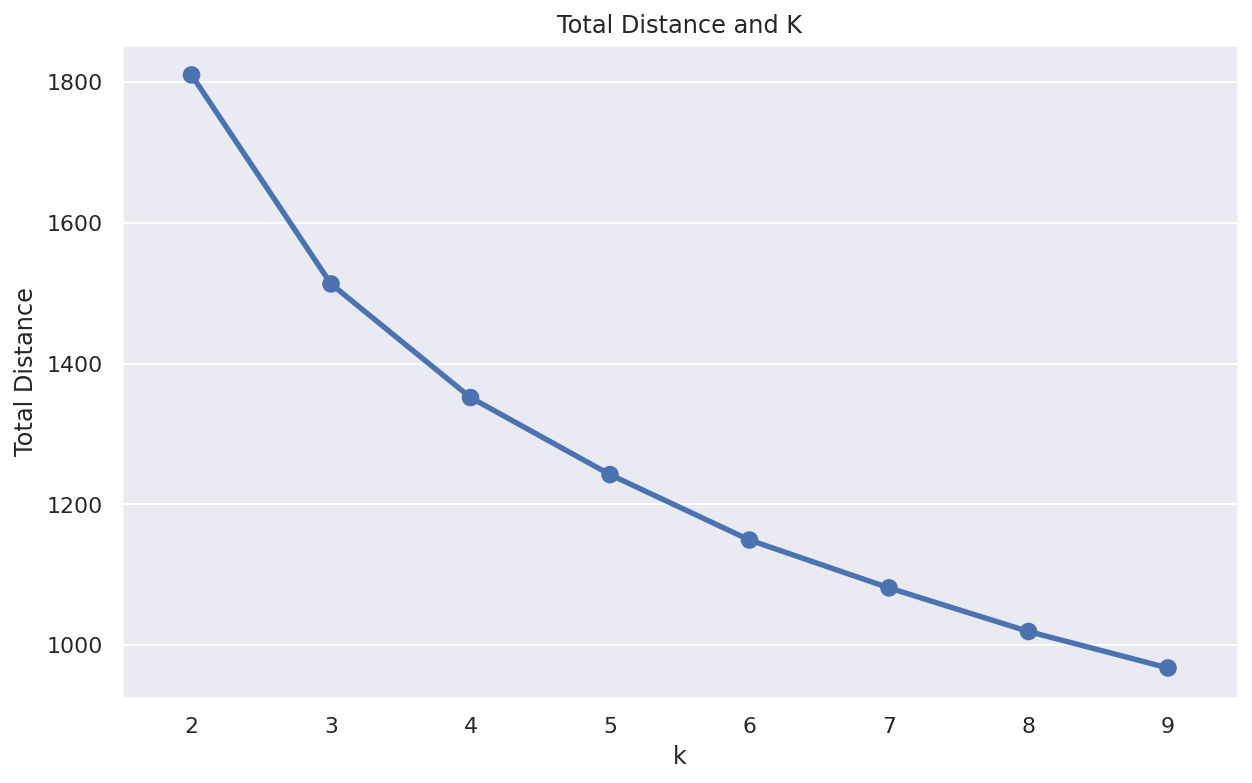

In [46]:
# try different k values to find the elbow
dist = {}

for k in range(2,10):
    kmeans = KMeans(n_clusters = k, random_state=1)
    cluster_labels = kmeans.fit_predict(data_normal)
    dist[k] = kmeans.inertia_
   
plt.figure(figsize=(10,6))
plt.xlabel('k')
plt.ylabel('Total Distance')
plt.title('Total Distance and K')
sns.pointplot(x = list(dist.keys()), y = list(dist.values()))

plt.show()

In [47]:
# k=3 
kmeans = KMeans(n_clusters = 3,max_iter = 1000, random_state = 1)
kmeans.fit(data_normal)
predict = kmeans.predict(data_normal)
centers = kmeans.cluster_centers_

In [48]:
# PCA with 3 components

pca = PCA(3)
while True: 
    try: 
        comp = pca.fit_transform(data_normal)
        break 
    except: 
        continue


print("How much of variance in data is explained by each 3 component:")
pca.explained_variance_ratio_

How much of variance in data is explained by each 3 component:


array([0.44889984, 0.28002326, 0.10189812])

In [49]:
first = comp[:, 0]
second = comp[:, 1]
third = comp[:, 2]
fig = explot.scatter_3d(x=first, y = second, z = third, color = predict, width=900, height=600)
fig.show()